# Rethinking link prediction 

The widely accepted link prediction benchmark is inadequate for assessing the precision of link prediction models, which is critical in applications, e.g., a low-precision recommendation system provides many false recommendations, hurting user experience. The inadequacy is attributed to two factors. First, the evaluation metric (AUC-ROC) neglects the practical importance of high-scoring predictions. Second, many false high-scoring predictions are omitted from the evaluation by the sampling of unconnected node pairs. The results presented in this notebook will demonstrate the limitations of current link prediction benchmark (and hopefully to provide some remedies).

## What is link prediction? And why it's important?

- Link prediction for networks is the task of predicting the connections between pairs of nodes in a network. 
- Link prediction has many application, such as recommendation systems, fraud detection, and knowledge discoveries. 
- Additionally, link prediction can be used to test hypotheses about network generation models, and successful link prediction provides insights into the underlying mechanisms that shape network structure. 

## Prevailing link prediction benchmark 

- A link prediction algorithm is evaluated based on its ability to predict missing edges that are actually present but not observed in a given network. 
- To test this, the algorithm is given a training network with missing edges and is required to provide a prediction score $s_{ij}$ for each pair of nodes $i$ and $j$. The higher the score, the greater the likelihood of an edge existing between those two nodes.
- Since there are significantly more unconnected nodes than missing edges due to edge sparsity, a subset of unconnected node pairs sampled uniformly at random is used, with the same size as the set of missing edges.
- The algorithm is deemed to be a successful link prediction algorithm if the score is higher for the missing edges (green in the figure below) than for the unconnected node pairs (red).
- The overlap of the distributions for the missing edges and unconnected node pairs is commonly quantified by the area under curve (AUC) of the receiving operator characteristics (ROC; right panel).


![](https://hrngok.github.io/images/roc10.jpg)


## Issue of the prevailing benchmark

Let us demonstrate the issue discussed above. We will use link prediction based on the preferential attachment, which gives the prediction score by   
$$
\begin{align}
s_{ij} = \log(d_i)  + \log(d_j),
\end{align}
$$ 
where $d_i$ is the degree of node $i$. We assume that the network is undirected and unweighted. For the network, we use the following network: 

In [1]:
network_name = "polblogs-rachith"
net_file_path = (
    f"../../mydata/derived/networks/preprocessed/{network_name}/edge_table.csv"
)

Let's import libraries and generate the dataset for link prediction:

In [2]:
from scipy import sparse
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# In-house
from linkpred.LinkPredictionDataset import LinkPredictionDataset
import embcom
import utils

edge_table = pd.read_csv(net_file_path, dtype={"src": int, "trg": int})
net = utils.edge2network(src=edge_table["src"], trg=edge_table["trg"])

# Construct the link prediction benchmark
lpmodel = LinkPredictionDataset(
    testEdgeFraction=0.5, negative_edge_sampler="uniform", all_negatives=True
)
lpmodel.fit(net)
train_net, test_edge_table = lpmodel.transform()

# To ensure that the network is undirected and unweighted
train_net = utils.toUndirected(train_net)

# src_test, trg_test, y = test_edge_table["src"].values, test_edge_table["trg"].values, test_edge_table["isPositiveEdge"].values
display(test_edge_table.groupby("isPositiveEdge").head(3))
print(
    f"Fraction of connected node pairs in the test edge set: %.3f"
    % test_edge_table["isPositiveEdge"].mean()
)

/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-24 06:16:42.244892: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-24 06:16:42.245159: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 06:16:42.248000: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Ignore this message if you do not use Glove. Otherwise, install glove python package by 'pip install glove_python_binary' 


,src,trg,isPositiveEdge
0,7,674,1
1,186,317,1
2,40,839,1
8357,0,5,0
8358,0,6,0
8359,0,7,0


Fraction of connected node pairs in the test edge set: 0.011


- The `test_edge_table` contains pairs of node IDs, and the `isPositiveEdge` flag indicates whether there is an edge between the two nodes; a value of one indicates that there is an edge, and a value of zero indicates that there is not. This table contains *all* unconnected node pairs, which will be sampled. 
- `train_net` is the training network consists of edges that are observed for the algorithm to be tested.


Let us calculate the prediction score based on the preferential attachment:

In [3]:
deg = np.array(train_net.sum(axis=1)).reshape(-1)
log_deg = np.log(np.maximum(deg, 1))
S = np.add.outer(log_deg, log_deg)

Now, let's compare the prediction score for the missing edges and unconnected node pairs. 

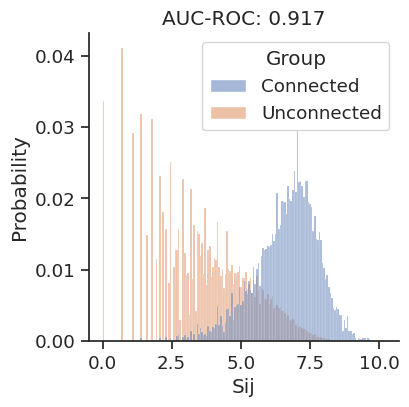

In [4]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {"Group": map(lambda x: ["Unconnected", "Connected"][x], y), "Sij": ypred}
)
ax = sns.histplot(
    data=df, x="Sij", hue="Group", common_norm=False, stat="probability", ax=ax
)
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
sns.despine()

It's impressive AUC-ROC score. Indeed, the preferential attachment achieves surprisingly (and spuriously) high AUC-ROC score given its simple formula.  Now, let's zoom in the area, where prediction score $s_{ij}$ is high. This time, we take the count as the y-axis instead of the probability:  

Sort the link prediction by Sij


,Group,Sij
16066,Unconnected,10.199696
11865,Unconnected,10.096378
11869,Unconnected,10.084183
16065,Unconnected,10.061773
11868,Unconnected,9.946260
16063,Unconnected,9.893437
2562,Connected,9.777924
15094,Unconnected,9.775881
16064,Unconnected,9.759906
5904,Connected,9.747711


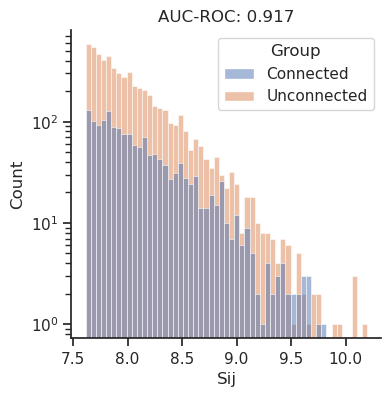

In [5]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {
        "Group": map(lambda x: ["Unconnected", "Connected"][x], y),
        "Sij": ypred,
    }
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"] >= s]
ax = sns.histplot(
    data=df,
    x="Sij",
    hue="Group",
    common_norm=False,
    stat="count",
    hue_order=["Connected", "Unconnected"],
    ax=ax,
)
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
# ax.legend(frameon=False, fontsize=12, labels = ["Connected", "Unconnected"])
sns.despine()
print("Sort the link prediction by Sij")
df.sort_values(by="Sij", ascending=False).head(10)

The right-tail of the distributions provide a critical observation: preferential attachment incorrectly predicted the edges with the highest scores. In fact, as we go through from the highest to lowest scoring link prediction, the preferential attachment made the first correct prediction after failing eight predictions. Discuss the implication for information retrieval. 

The result provides a practical implication: preferential attachment is not a reliable link prediction method. This could be a major issue for recommendation systems because making many false predictions may harm user experience.

To be worse, most false predictions are unlikely to be counted in the prevailing benchmark because of the sampling of unconnected node pairs. To see this, let us randomly sample the unconnected node pairs, with the same size as the positive edges by following the accepted practice.

In [6]:
n_positives = int(test_edge_table["isPositiveEdge"].sum())
sampled_test_edge_table = (
    test_edge_table.sample(frac=1).groupby("isPositiveEdge").head(n_positives)
)
print(
    f"Fraction of connected node pairs in the test edge set: %.2f"
    % sampled_test_edge_table["isPositiveEdge"].mean()
)

Fraction of connected node pairs in the test edge set: 0.50


Second, let's see the distribution of the prediction score:

Sort the link prediction by Sij


,Group,Sij
15495,Connected,9.777924
12159,Connected,9.747711
11304,Connected,9.670294
14068,Connected,9.658098
14218,Connected,9.644393
12963,Connected,9.609787
14933,Connected,9.605553
15135,Connected,9.604610
15080,Connected,9.583282
16304,Connected,9.554781


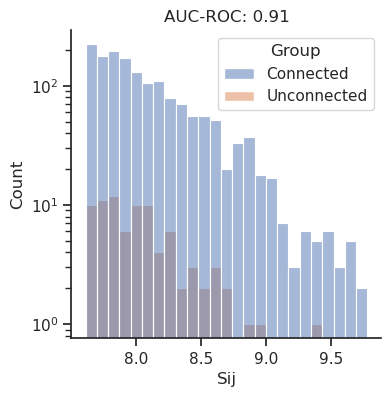

In [7]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(sampled_test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {
        "Group": map(lambda x: ["Unconnected", "Connected"][x], y),
        "Sij": ypred,
    }
)
df = df[df["Sij"] >= s]
ax = sns.histplot(
    data=df,
    x="Sij",
    hue="Group",
    common_norm=False,
    stat="count",
    hue_order=["Connected", "Unconnected"],
    ax=ax,
)
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.2f}")
sns.despine()
print("Sort the link prediction by Sij")
df.sort_values(by="Sij", ascending=False).head(10)

Most high-scoring unconnected node pairs disappear, since they make up a small portion of all unconnected node pairs and therefore are unlikely to be chosen for evaluation.

Now, let's consider another more sophisticated prediction algorithm: the graph convolution network (GCN). We use GCN to learn a vector representation of nodes and compute the prediction score $s_{ij}$ by the dot-similarity of two nodes.  

In [8]:
# Learning embedding 
emb = utils.embedding_models["GCN"](train_net, dim = 64, device = "cuda:0")

# making prediction by the dot-similarity 
S = emb @ emb.T

100%|██████████| 1001/1001 [00:20<00:00, 48.14it/s]


The distributions of prediction scores for the missing and unconnected node pairs:

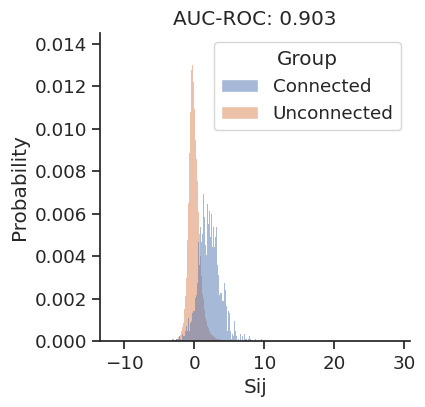

In [9]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {"Group": map(lambda x: ["Unconnected", "Connected"][x], y), "Sij": ypred}
)
ax = sns.histplot(
    data=df, x="Sij", hue="Group", common_norm=False, stat="probability", ax=ax
)
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
sns.despine()

Notice that the AUC-ROC score is *lower* than the preferential attachment. And thus, with the current link prediction benchmark, GCN is not deemed as a better prediction method. Or is it? Let's zoom in the right-tail of the distribution to see the top-scoring predictions.  

Sort the link prediction by Sij


,Group,Sij
624580,Unconnected,3.361491
729498,Unconnected,2.896760
723096,Unconnected,2.883557
723769,Unconnected,2.760031
730485,Unconnected,2.753183
480593,Unconnected,2.712284
480633,Unconnected,2.712284
723700,Unconnected,2.676517
722988,Unconnected,2.658549
729436,Unconnected,2.657607


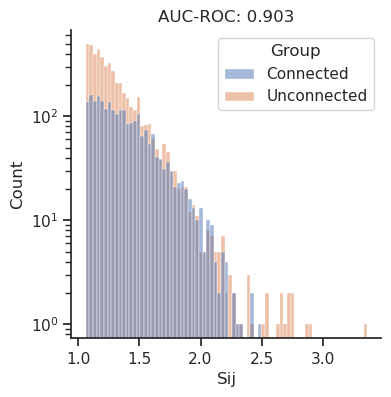

In [10]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {
        "Group": map(lambda x: ["Unconnected", "Connected"][x], y),
        "Sij": np.log(np.maximum(ypred, 1)),
    }
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"] >= s]
ax = sns.histplot(
    data=df,
    x="Sij",
    hue="Group",
    common_norm=False,
    stat="count",
    hue_order=["Connected", "Unconnected"],
    ax=ax,
)
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
# ax.legend(frameon=False, fontsize=12, labels = ["Connected", "Unconnected"])
sns.despine()
print("Sort the link prediction by Sij")
df.sort_values(by="Sij", ascending=False).head(10)

Although GCN failed for its highest-scoring prediction, it accurately predicted six missing edges among the top 9 prediction, which is six times better than the preferential attachment in terms of precision. In other words, GCN provides more reliable prediction with much higher precision than preferential attachment. 

As is seen for the preferential attachment, sampling the unconnected node pairs leads to a spuriously better picture: 

Sort the link prediction by Sij


,Group,Sij
14933,Connected,2.480293
14218,Connected,2.430011
16304,Connected,2.409331
11561,Connected,2.322891
9547,Connected,2.309209
13798,Connected,2.262548
15135,Connected,2.259558
10070,Connected,2.223591
13895,Connected,2.222615
12803,Connected,2.212343


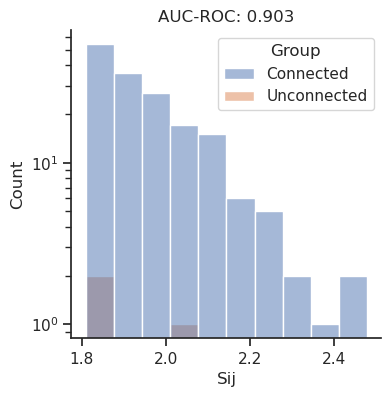

In [11]:

sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

src_test, trg_test, y = tuple(sampled_test_edge_table.values.T)
ypred = S[(src_test, trg_test)]
aucroc = roc_auc_score(y, ypred)

df = pd.DataFrame(
    {
        "Group": map(lambda x: ["Unconnected", "Connected"][x], y),
        "Sij": np.log(np.maximum(ypred, 1)),
    }
)
s = np.quantile(df["Sij"], 0.99)
df = df[df["Sij"] >= s]
ax = sns.histplot(
    data=df,
    x="Sij",
    hue="Group",
    common_norm=False,
    stat="count",
    hue_order=["Connected", "Unconnected"],
    ax=ax,
)
ax.set_yscale("log")
ax.set_title(f"AUC-ROC: {aucroc:.3f}")
# ax.legend(frameon=False, fontsize=12, labels = ["Connected", "Unconnected"])
sns.despine()
print("Sort the link prediction by Sij")
df.sort_values(by="Sij", ascending=False).head(10)

The results presented in this notebook serves as a warning that the current link prediction benchmark fails to accurately measure the precision of different link prediction models. This inadequacy is attributed to two factors: 
1. High-scoring predictions are more important than low-scoring prediction in applications, although they have a little impact on AUC-ROC, as it reflects the overall accuracy of prediction. 
2. Sampling unconnected node pairs removes many false high-scoring predictions, making it challenging to assess the precision of link prediction. 
